# Dimensionality Reduction

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Union

from sklearn.metrics import confusion_matrix
from scipy.stats import norm

In [16]:
# Performance evaluation function for Classification --------------------------
def perf_eval_clf(y_true: Union[np.array,list], y_pred: Union[np.array,list])->list:
    """
    Input:
    y_true : ndarray of shape (n_samples,)
    y_pred : ndarray of shape (n_samples,)
    Return:
    [TPR,Precision,TNR, Accuracy, BCR, F1]: scores of classification in a list
    """
    cm = confusion_matrix(y_true = y_true, y_pred = y_pred)
    print(f"Confusion Matrix:\n{cm}")
    tn, fp, fn, tp = cm.ravel()
    TPR = round(tp/(tp+fn),3) #==recall
    PRE = round(tp/(tp+fp),3)
    TNR = round(tn/(tn+fp),3)
    ACC = round((tp+tn)/(tp+tn+fp+fn), 3)
    BCR = round(np.sqrt([TPR*TNR])[0],3)
    F1 = round(2*TPR*PRE/(TPR+PRE),3)
    return [TPR, PRE, TNR, ACC, BCR, F1]
    

In [17]:
def display_result(result_dict: dict, metric_names: list = ['TPR(Recall)','Precision','TNR','ACC','BCR','F1']):
    
    result_df = pd.DataFrame(result_dict).T
    result_df.index = list(result_dict.keys())
    result_df.columns = metric_names
    
    display(result_df)
    
result_dict = {}

In [18]:
def display_coefs(model, name: str) -> None:
    """
    input:
    model: fitted model with given variables
    name: name of the model
    """
    features = ['Constant']+model.feature_names_in_.tolist() if model.intercept_ else model.feature_names_in_.tolist()
    coefs = [model.intercept_[0]]+model.coef_[0].tolist() if model.intercept_ else model.coef_[0].tolist()
    print(f'Model : {name}')
    display(pd.DataFrame({'features':features,'coefs':coefs}))

In [19]:
from sklearn.preprocessing import scale
ploan = pd.read_csv("Personal Loan.csv")
# Indices for the activated input variables
#input_idx = set(range(len(ploan.columns.tolist())))-set([0,4,9])
#input_idx = list(input_idx)
input_idx = [1,2,3,5,6,7,8,10,11,12,13]
target_idx = 9
ploan_input = ploan.iloc[:,input_idx]
ploan_input_scaled = scale(ploan_input,axis =0, with_mean=True, with_std=True)
ploan_target = ploan.iloc[:,target_idx]
ploan_data = pd.concat((ploan_input,ploan_target),axis=1)

In [54]:
ploan_trn = ploan_data.iloc[:1500,:]
ploan_tst = ploan_data.iloc[1500:,:]
x_trn, y_trn = ploan_trn.iloc[:,:-1],ploan_trn.iloc[:,-1]
x_tst, y_tst = ploan_tst.iloc[:,:-1],ploan_tst.iloc[:,-1]
# feature names
feature_names = list(x_trn.columns)
max_features = len(x_trn.columns)

In [21]:
def logit_pvalue(model,x,feature_names,cls=0):
    p1 = model.predict_proba(x)
    n1 = len(p1)
    m1 = len(model.coef_[cls]) + 1
    if len(model.intercept_)>1:
        feature_names=['constant'] + feature_names
        coefs = np.concatenate([np.array(model.intercept_[cls].reshape(1,)), model.coef_[cls]])
    elif len(model.intercept_)==1:
        feature_names=['constant'] + feature_names
        coefs = np.concatenate([model.intercept_, model.coef_[0]])
    else:
        coefs = model.coef_[cls]
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    answ = np.zeros((m1, m1))
    for i in range(n1):
        answ = answ + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p1[i,1] * p1[i, 0]
    vcov = np.linalg.inv(np.matrix(answ))
    se = np.sqrt(np.diag(vcov))
    t1 = coefs/se
    p1 = (1 - norm.cdf(abs(t1))) * 2
    pvalue_dict = {key:round(value,4) for key,value in zip(feature_names,p1)}
    display(pd.DataFrame(pvalue_dict,columns=pvalue_dict.keys(),index=['P-value']).T)
    return pvalue_dict

## 1. All variables

In [22]:
from sklearn.linear_model import LogisticRegression
seed = 1234
full_config = {
    'penalty': None,
    'fit_intercept':True,
    'max_iter':int(1e+5),
    'solver':'saga',
    'random_state':seed,
    'n_jobs':-1
}

#solving name of the selected features
features_dict = {}
features_dict['All Variables'] = ['constant']+feature_names

full_model = LogisticRegression(**full_config).fit(x_trn,y_trn)
logit_pvalue(full_model, x_trn, feature_names)


y_pred = full_model.predict(x_tst)
result_dict['All variables'] = perf_eval_clf(y_tst,y_pred)
display_coefs(full_model, 'All_variables')
display_result(result_dict,)

,P-value
constant,0.9835
Age,0.0008
Experience,0.0007
Income,0.0000
Family,0.0000
CCAvg,0.0553
Education,0.0000
Mortgage,0.8055
Securities Account,0.9961
CD Account,0.3465


Confusion Matrix:
[[876  20]
 [ 47  57]]
Model : All_variables


,features,coefs
0,Constant,-0.063633
1,Age,-0.411730
2,Experience,0.418377
3,Income,0.042928
4,Family,0.557976
5,CCAvg,0.107522
6,Education,0.977913
7,Mortgage,0.000215
8,Securities Account,-0.001934
9,CD Account,0.413303


,TPR(Recall),Precision,TNR,ACC,BCR,F1
All variables,0.548,0.74,0.978,0.933,0.732,0.63


## 2. Forward Selection

In [23]:
from sklearn.feature_selection import SequentialFeatureSelector as SFS
full_config = {
'penalty':None,
'fit_intercept':True,
'max_iter':int(1e+5),
'solver':'saga',
'random_state':seed,
'n_jobs':-1
}

full_model = LogisticRegression(**full_config)

# fitting SequentialFeatureSelector
forward_config = {
    'estimator':full_model,
    'n_features_to_select':'auto', #변수개수 지정
    'tol':1e-4, #성능차이 이정도면 stop
    'direction':'forward',
    'scoring':'f1',
    'cv':5, #cross validation
    'n_jobs':-1
    }

forward_selection = SFS(**forward_config).fit(x_trn,y_trn)
features_dict['Forward Selection']=forward_features = forward_selection.get_feature_names_out()
print(forward_features)

['Income' 'CCAvg' 'Education' 'Securities Account' 'CD Account'
 'CreditCard']


In [24]:
x_trn_forward = x_trn[forward_features]
x_tst_forward = x_tst[forward_features]
forward_logit = LogisticRegression(**full_config).fit(x_trn_forward,y_trn)
y_pred = forward_logit.predict(x_tst_forward)

logit_pvalue(forward_logit, x_trn_forward, x_trn_forward.columns.tolist())
result_dict['Forward Selection'] = perf_eval_clf(y_tst,y_pred)
display_coefs(forward_logit, 'Forward_selection')
display_result(result_dict)

,P-value
constant,0.0000
Income,0.0000
CCAvg,0.1654
Education,0.0000
Securities Account,0.0784
CD Account,0.0000
CreditCard,0.0007


Confusion Matrix:
[[883  13]
 [ 47  57]]
Model : Forward_selection


,features,coefs
0,Constant,-6.197537
1,Income,0.028730
2,CCAvg,0.071035
3,Education,0.620194
4,Securities Account,-0.678454
5,CD Account,2.323604
6,CreditCard,-0.965712


,TPR(Recall),Precision,TNR,ACC,BCR,F1
All variables,0.548,0.740,0.978,0.933,0.732,0.630
Forward Selection,0.548,0.814,0.985,0.940,0.735,0.655


# 3. Backward Elimination

direction을 'backward'로 설정하면 된다.

In [28]:
full_config = {
'penalty':'none',
'fit_intercept':True,
'max_iter':int(1e+5),
'solver':'saga',
'random_state':seed,
'n_jobs':-1
}
full_model = LogisticRegression(**full_config)

backward_config = {
'estimator':full_model,
'n_features_to_select':'auto',
'tol':1e-3,
'direction':'backward',
'scoring':'f1',
'cv':5,
'n_jobs':-1
}

backward_eliminaion =SFS(**backward_config).fit(x_trn,y_trn)
features_dict['Backward Elimination'] = backward_features = backward_eliminaion.get_feature_names_out()
print(backward_features)

['Age' 'Experience' 'Income' 'Family' 'Education' 'Securities Account'
 'CD Account' 'CreditCard']


In [29]:
# Training Logistic Regression with selected features
x_trn_backward = x_trn[backward_features]
x_tst_backward = x_tst[backward_features]
backward_logit = LogisticRegression(**full_config).fit(x_trn_backward,y_trn)
y_pred = backward_logit.predict(x_tst_backward)
result_dict['Backward Elimination'] = perf_eval_clf(y_tst,y_pred)
display_result(result_dict)

c:\Users\se99a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Confusion Matrix:
[[883  13]
 [ 43  61]]


,TPR(Recall),Precision,TNR,ACC,BCR,F1
All variables,0.548,0.740,0.978,0.933,0.732,0.630
Forward Selection,0.548,0.814,0.985,0.940,0.735,0.655
Backward Selection,0.548,0.814,0.985,0.940,0.735,0.655
Backward Elimination,0.587,0.824,0.985,0.944,0.760,0.686


## 4. Stepwise Selection


tolerance를 None, direction을 'forward'로 주면 된다.

In [31]:
full_config = {
'penalty':'none',
'fit_intercept':True,
'max_iter':int(1e+5),
'solver':'saga',
'random_state':seed,
'n_jobs':-1
}
full_model = LogisticRegression(**full_config)

stepwise_config = {
'estimator':full_model,
'n_features_to_select':'auto',
'tol':None,
'direction':'forward',
'scoring':'f1',
'cv':5,
'n_jobs':-1
}
stepwise_selection =SFS(**stepwise_config).fit(x_trn,y_trn)
features_dict['Stepwise Selection']= stepwise_features = stepwise_selection.get_feature_names_out()
print(stepwise_features)

['Income' 'Education' 'Securities Account' 'CD Account' 'CreditCard']


In [33]:
x_trn_stepwise = x_trn[stepwise_features]
x_tst_stepwise = x_tst[stepwise_features]
stepwise_logit = LogisticRegression(**full_config).fit(x_trn_stepwise,y_trn)
y_pred = stepwise_logit.predict(x_tst_stepwise)
result_dict['Stepwise Selection'] = perf_eval_clf(y_tst,y_pred)
display_result(result_dict)

c:\Users\se99a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Confusion Matrix:
[[881  15]
 [ 48  56]]


,TPR(Recall),Precision,TNR,ACC,BCR,F1
All variables,0.548,0.740,0.978,0.933,0.732,0.630
Forward Selection,0.548,0.814,0.985,0.940,0.735,0.655
Backward Selection,0.548,0.814,0.985,0.940,0.735,0.655
Backward Elimination,0.587,0.824,0.985,0.944,0.760,0.686
Stepwise Selection,0.538,0.789,0.983,0.937,0.727,0.640


## 5. Genetic Algorithm

In [45]:
ch = np.bool_(np.ones(11))
ch[:int(0.3*11)]=False
np.random.shuffle(ch)
x_trn.iloc[:,ch]

,Age,Experience,Income,Family,CCAvg,Education,Securities Account,CreditCard
0,25,1,49,4,1.6,1,1,0
1,45,19,34,3,1.5,1,1,0
2,39,15,11,1,1.0,1,0,0
3,35,9,100,1,2.7,2,0,0
4,35,8,45,4,1.0,2,0,1
...,...,...,...,...,...,...,...,...
1495,52,28,178,3,5.4,3,0,0
1496,36,12,18,1,0.5,3,0,1
1497,45,21,73,1,0.8,3,0,0
1498,49,23,125,1,7.3,1,0,0


In [56]:
from sklearn.metrics import f1_score

class GeneticAlgorithm(object):
    def __init__(self,
                 population_size : int,
                 n_feat: int,
                 n_parents: int,
                 n_gen: int,
                 init_rate: int,
                 mutation_rate: float,
                 crossover_rate: float,
                 model: object,
                 seed: int)->None:
        
        self.population_size = population_size
        self.n_feat = n_feat
        self.n_parents = n_parents
        self.n_gen = n_gen
        self.init_rate = init_rate
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.model = model
        self.seed = seed
    
    
    def initialization_of_population(self, size: int, n_feat: int, init_prob: float)->list:
        population = []
        for i in range(size):
            chromosome = np.bool_(np.ones(n_feat))
            chromosome[:int(init_prob*n_feat)]=False
            np.random.shuffle(chromosome)
            population.append(chromosome)
            
        return population


    def fitness_score(self, model, population:list, X_train:Union[np.array,pd.DataFrame],Y_train:Union[np.array,pd.DataFrame]):
        scores = []
        for chromosome in population:
            model.fit(X_train.iloc[:,chromosome],Y_train)
            predictions = model.predict(X_train.iloc[:,chromosome])
            scores.append(f1_score(Y_train,predictions))
        scores, population = np.array(scores), np.array(population)
        inds = np.argsort(scores)
        return list(scores[inds][::-1]), list(population[inds,:][::-1])

    def selection(self,pop_after_fit,n_parents):
        population_nextgen = []
        for i in range(n_parents):
            population_nextgen.append(pop_after_fit[i])
        return population_nextgen

    def crossover(self,pop_after_sel:list, crossover_rate:float):
        pop_nextgen = pop_after_sel
        for i in range(0, len(pop_after_sel),2):
            new_par = []
            child_1, child_2 = pop_nextgen[i], pop_nextgen[i+1]
            select_idx = np.random.random_sample(len(child_1))>crossover_rate
            for j in range(len(child_1)):
                new_par.append(child_1[j] if select_idx[j] else child_2[j])
            pop_nextgen.append(new_par)
        return pop_nextgen

    def mutation(self, pop_after_cross:list, mutation_rate:float, n_feat:int):
        mutation_range = int(mutation_rate*n_feat)
        pop_next_gen = []
        for n in range(0, len(pop_after_cross)):
            chromo = pop_after_cross[n]
            rand_posi = []
            for i in range(0, mutation_range):
                pos = np.random.randint(0, n_feat-1)
                rand_posi.append(pos)
            for j in rand_posi:
                chromo[j] = not chromo[j]
            pop_next_gen.append(chromo)
        return pop_next_gen

    def fit(self,
        x_trn:Union[np.array, pd.DataFrame],
        y_trn:Union[np.array, pd.Series,list,],
        ):
        np.random.seed(self.seed)
        best_chromo= []
        best_score= []
        population_nextgen = self.initialization_of_population(self.population_size, self.n_feat, self.init_rate)
        for i in range(self.n_gen):
            scores, pop_after_fit = self.fitness_score(self.model, population_nextgen, x_trn, y_trn)
            best_chromo.append(pop_after_fit[0])
            best_score.append(scores[0])
            print('Best score(Training) in generation',i+1,':',scores[:1]) #2
            pop_after_sel = self.selection(pop_after_fit,self.n_parents)
            pop_after_cross = self.crossover(pop_after_sel,self.crossover_rate)
            population_nextgen = self.mutation(pop_after_cross, self.mutation_rate, self.n_feat)
            
        return best_chromo, best_score

In [59]:
full_config = {
'penalty':'none',
'fit_intercept':True,
'max_iter':int(1e+5),
'solver':'saga',
'random_state':seed,
'n_jobs':-1
}
full_model = LogisticRegression(**full_config)

In [60]:
genetic_config={
'population_size':20,
'n_feat':max_features,
'n_parents':2,
'n_gen':5,
'init_rate':0.3,
'mutation_rate':0.1,
'crossover_rate':0.3,
'model':full_model,
'seed':seed
}
GA = GeneticAlgorithm(**genetic_config)
bestchromo,bestscores = GA.fit(x_trn,y_trn)
features_dict['Genetic Algorithm'] = genetic_features =np.array(feature_names)[bestchromo[np.argmax(bestscores)]].tolist()
print(genetic_features)


c:\Users\se99a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\se99a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\se99a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\se99a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\se99a\anaconda3\lib\site-packages\sklearn\linear_model\

Best score(Training) in generation 1 : [0.6973180076628352]


c:\Users\se99a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\se99a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\se99a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Best score(Training) in generation 2 : [0.6943396226415095]


c:\Users\se99a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\se99a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\se99a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Best score(Training) in generation 3 : [0.6973180076628352]


c:\Users\se99a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\se99a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\se99a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Best score(Training) in generation 4 : [0.7022900763358779]


c:\Users\se99a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\se99a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\se99a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Best score(Training) in generation 5 : [0.6969696969696969]
['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Education', 'Online', 'CreditCard']


In [61]:
x_trn_genetic = x_trn[genetic_features]
x_tst_genetic = x_tst[genetic_features]
genetic_logit = LogisticRegression(**full_config).fit(x_trn_genetic,y_trn)
y_pred = genetic_logit.predict(x_tst_genetic)
result_dict['Genetic Algorithm'] = perf_eval_clf(y_tst,y_pred)
display_result(result_dict)

c:\Users\se99a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Confusion Matrix:
[[875  21]
 [ 44  60]]


,TPR(Recall),Precision,TNR,ACC,BCR,F1
All variables,0.548,0.740,0.978,0.933,0.732,0.630
Forward Selection,0.548,0.814,0.985,0.940,0.735,0.655
Backward Selection,0.548,0.814,0.985,0.940,0.735,0.655
Backward Elimination,0.587,0.824,0.985,0.944,0.760,0.686
Stepwise Selection,0.538,0.789,0.983,0.937,0.727,0.640
Genetic Algorithm,0.577,0.741,0.977,0.935,0.751,0.649


## 6. Ridge Regression

In [66]:
from sklearn.linear_model import LogisticRegressionCV
seed = 1234
ridge_config = {
'Cs':10,
'fit_intercept':True,
'penalty':'l2',
'scoring':'f1',
'solver':'saga',
'tol':1e-4,
'max_iter':int(1e+5),
'random_state':seed,
'n_jobs':-1,
'refit':True,
}
ridge_regression = LogisticRegressionCV(**ridge_config).fit(x_trn,y_trn)
best_C = ridge_regression.C_ # best C
print(f"Best 'C':{best_C}")
# Best 'C':[2.7825594]


Best 'C':[2.7825594]


In [67]:
# Coefficients
best_coefs = ridge_regression.intercept_.tolist()+ridge_regression.coef_[0].tolist()
feature_names = ['Constant']+ridge_regression.feature_names_in_.tolist()
display(pd.DataFrame({'features':feature_names,'coefs':best_coefs}))

,features,coefs
0,Constant,-0.163167
1,Age,-0.404805
2,Experience,0.411334
3,Income,0.042725
4,Family,0.544873
5,CCAvg,0.106745
6,Education,0.971845
7,Mortgage,0.000219
8,Securities Account,-0.004046
9,CD Account,0.425316


(-4.4, 4.4, -0.45925274407483974, 0.9712935539138013)

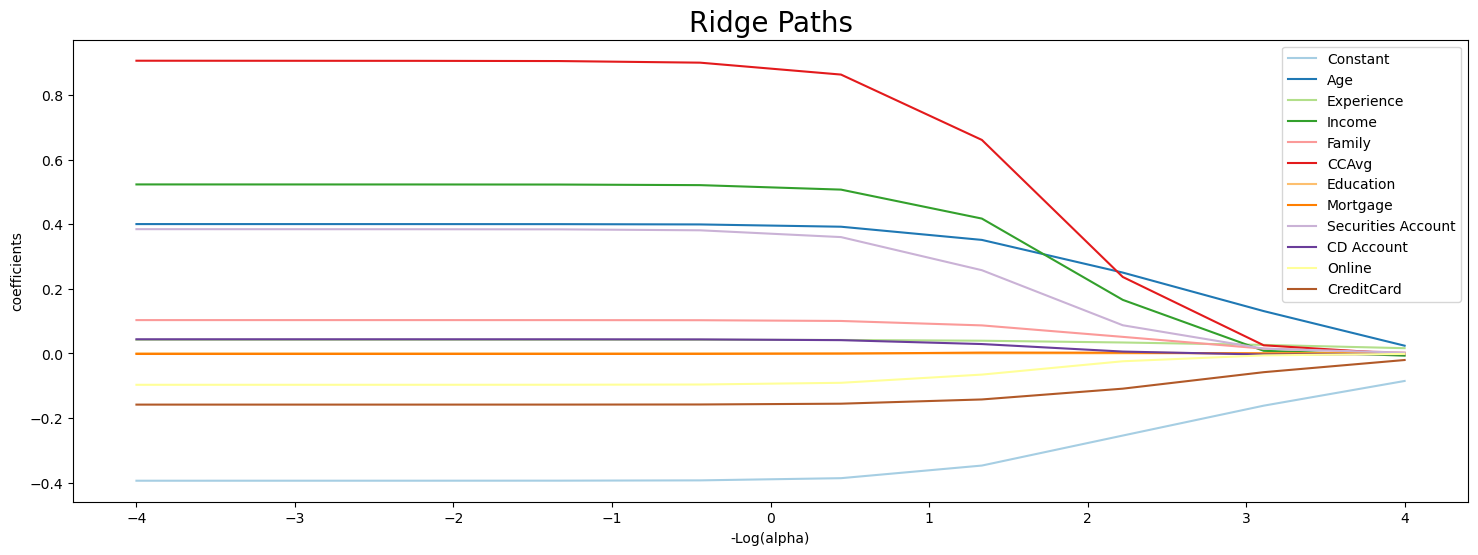

In [68]:
# Display results
alphas_ridge,coefs_ridge =ridge_regression.Cs_, np.mean(ridge_regression.coefs_paths_[1],axis=0).T
plt.figure(figsize=(18,6))
colors = plt.cm.Paired.colors
neg_log_alphas_ridge = -np.log10(alphas_ridge)
for coef_l, c, feature in zip(coefs_ridge, colors, feature_names):
    l1 = plt.plot(neg_log_alphas_ridge, coef_l,c=c,label=feature)
plt.xlabel("-Log(alpha)")
plt.ylabel("coefficients")
plt.title("Ridge Paths",fontsize=20)
plt.legend()
plt.axis("tight")

In [71]:
y_ridge_pred = ridge_regression.predict(x_tst)
result_dict['Ridge Regression'] = perf_eval_clf(y_tst,y_ridge_pred)
display_coefs(ridge_regression, 'Ridge Regression')
display_result(result_dict)


Confusion Matrix:
[[875  21]
 [ 47  57]]
Model : Ridge Regression


,features,coefs
0,Constant,-0.163167
1,Age,-0.404805
2,Experience,0.411334
3,Income,0.042725
4,Family,0.544873
5,CCAvg,0.106745
6,Education,0.971845
7,Mortgage,0.000219
8,Securities Account,-0.004046
9,CD Account,0.425316


,TPR(Recall),Precision,TNR,ACC,BCR,F1
All variables,0.548,0.740,0.978,0.933,0.732,0.630
Forward Selection,0.548,0.814,0.985,0.940,0.735,0.655
Backward Elimination,0.587,0.824,0.985,0.944,0.760,0.686
Stepwise Selection,0.538,0.789,0.983,0.937,0.727,0.640
Genetic Algorithm,0.577,0.741,0.977,0.935,0.751,0.649
Ridge Regression,0.548,0.731,0.977,0.932,0.732,0.626


Ridge의 경우 성능향상보다는 coef가 0값을 나타내는지 여부 확인이 중요

## 7. Lasso Regression

In [73]:
lasso_config = {
'Cs':10,
'fit_intercept':True,
'penalty':'l1',
'scoring':'f1',
'solver':'saga',
'tol':1e-4,
'max_iter':int(1e+5),
'random_state':seed,
'n_jobs':-1,
'refit':True,
}
lasso_regression = LogisticRegressionCV(**lasso_config).fit(x_trn,y_trn)
best_C = lasso_regression.C_
print(f"Best 'C':{best_C}")

Best 'C':[2.7825594]


In [74]:
best_coefs = lasso_regression.intercept_.tolist()+lasso_regression.coef_[0].tolist()
feature_names = ['Constant']+lasso_regression.feature_names_in_.tolist()
display(pd.DataFrame({'features':feature_names,'coefs':best_coefs}))

,features,coefs
0,Constant,-1.055360
1,Age,-0.367743
2,Experience,0.375083
3,Income,0.042798
4,Family,0.523788
5,CCAvg,0.105863
6,Education,0.977454
7,Mortgage,0.000231
8,Securities Account,0.000000
9,CD Account,0.229046


(-4.4, 4.4, -1.1491469913508248, 1.0105984942379669)

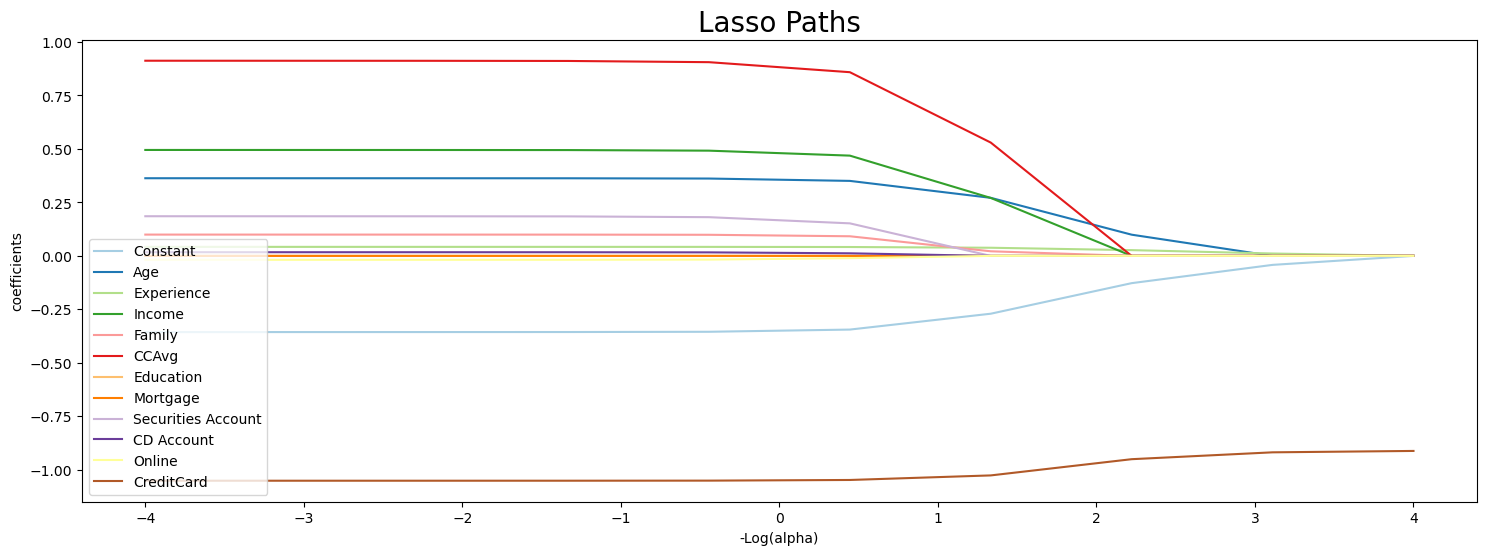

In [75]:
# Display results
alphas_lasso,coefs_lasso =lasso_regression.Cs_, np.mean(lasso_regression.coefs_paths_[1],axis=0).T
plt.figure(figsize=(18,6))
colors = plt.cm.Paired.colors
neg_log_alphas_lasso = -np.log10(alphas_lasso)
for coef_l, c, feature in zip(coefs_lasso, colors, feature_names):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l,c=c,label=feature)
plt.xlabel("-Log(alpha)")
plt.ylabel("coefficients")
plt.title("Lasso Paths",fontsize=20)
plt.legend()
plt.axis("tight")

In [76]:
# get the results
y_lasso_pred = lasso_regression.predict(x_tst)
result_dict['Lasso Regression'] = perf_eval_clf(y_tst,y_lasso_pred)
display_result(result_dict)


Confusion Matrix:
[[876  20]
 [ 47  57]]


,TPR(Recall),Precision,TNR,ACC,BCR,F1
All variables,0.548,0.740,0.978,0.933,0.732,0.630
Forward Selection,0.548,0.814,0.985,0.940,0.735,0.655
Backward Elimination,0.587,0.824,0.985,0.944,0.760,0.686
Stepwise Selection,0.538,0.789,0.983,0.937,0.727,0.640
Genetic Algorithm,0.577,0.741,0.977,0.935,0.751,0.649
Ridge Regression,0.548,0.731,0.977,0.932,0.732,0.626
Lasso Regression,0.548,0.740,0.978,0.933,0.732,0.630


## 8. Elastic Net

In [79]:
seed = 1234
elastic_config = {
'Cs':10,
'fit_intercept':True,
'penalty':'elasticnet',
'scoring':'f1',
'solver':'saga',
'tol':1e-4,
'max_iter':int(1e+5),
'random_state':seed,
'n_jobs':-1,
'refit':True,
'l1_ratios':[0.3,0.5,0.7] #cross validation으로 최적의 값 선택.
}
elastic_regression = LogisticRegressionCV(**elastic_config).fit(x_trn,y_trn)
best_C,best_l1_ratio = elastic_regression.C_,elastic_regression.l1_ratio_
print(f"Best 'C':{best_C}")
print(f"Best 'l1_ratio':{best_l1_ratio}")
# Best 'C':[2.7825594]
# Best 'l1_ratio':[0.3]


Best 'C':[2.7825594]
Best 'l1_ratio':[0.3]


In [80]:
best_coefs = elastic_regression.intercept_.tolist()+elastic_regression.coef_[0].tolist()
feature_names = ['Constant']+elastic_regression.feature_names_in_.tolist()
display(pd.DataFrame({'features':feature_names,'coefs':best_coefs}))

,features,coefs
0,Constant,-2.315201
1,Age,-0.320886
2,Experience,0.328821
3,Income,0.042974
4,Family,0.544515
5,CCAvg,0.108342
6,Education,0.969251
7,Mortgage,0.000217
8,Securities Account,-0.000839
9,CD Account,0.350433


(-4.4, 4.4, -1.765595746897096, 1.0351652528070259)

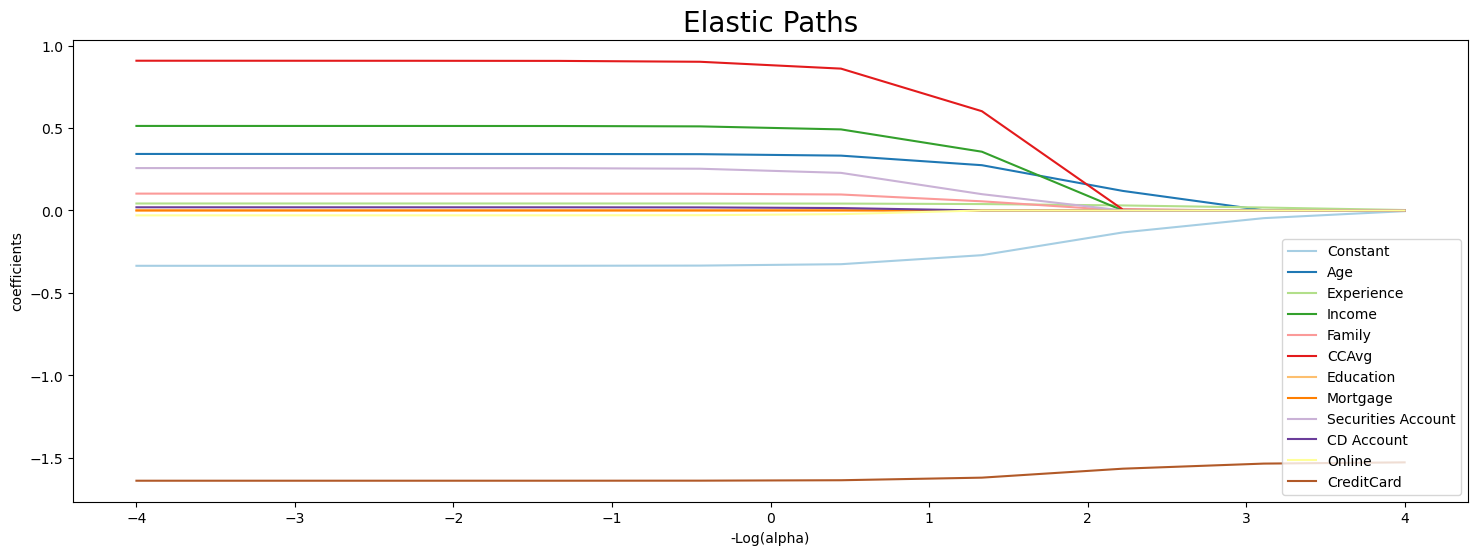

In [82]:
# Display results
alphas_elastic,coefs_elastic =elastic_regression.Cs_, np.mean(np.mean(elastic_regression.coefs_paths_[1],axis=0),axis=1).T
plt.figure(figsize=(18,6))
colors = plt.cm.Paired.colors
neg_log_alphas_elastic = -np.log10(alphas_elastic)
for coef_l, c, feature in zip(coefs_elastic, colors, feature_names):
    l1 = plt.plot(neg_log_alphas_elastic, coef_l,c=c,label=feature)
plt.xlabel("-Log(alpha)")
plt.ylabel("coefficients")
plt.title("Elastic Paths",fontsize=20)
plt.legend()
plt.axis("tight")

In [83]:
y_elastic_pred = elastic_regression.predict(x_tst)
result_dict['Elastic Net'] = perf_eval_clf(y_tst,y_elastic_pred)
display_result(result_dict)

Confusion Matrix:
[[876  20]
 [ 47  57]]


,TPR(Recall),Precision,TNR,ACC,BCR,F1
All variables,0.548,0.740,0.978,0.933,0.732,0.630
Forward Selection,0.548,0.814,0.985,0.940,0.735,0.655
Backward Elimination,0.587,0.824,0.985,0.944,0.760,0.686
Stepwise Selection,0.538,0.789,0.983,0.937,0.727,0.640
Genetic Algorithm,0.577,0.741,0.977,0.935,0.751,0.649
Ridge Regression,0.548,0.731,0.977,0.932,0.732,0.626
Lasso Regression,0.548,0.740,0.978,0.933,0.732,0.630
Elastic Net,0.548,0.740,0.978,0.933,0.732,0.630


In [ ]:
display_coefs()